In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline

/Users/vitorhadad/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# <center> EC3389 - Week 6 - Cross-validation </center>

In [2]:
import sklearn.cross_validation as skv
import sklearn.linear_model as skl
import sklearn.neighbors as skn
import sklearn.learning_curve as skc
import sklearn.metrics as skm

<hr>

<b>Exercise</b>  Create a function <font face="Courier">generate_data</font> that takes an integer <font face="Courier">n_points</font> a float $a$, and returns a tuple of three numpy arrays:

+ An array $X$ of <font face= "Courier">n_points</font> linearly spaced data on $[0,\pi]$

+ An array $y\_true_{i} = cos(a x_{i})$

+ An array $y_{i} = cos(a x_{i}) + \epsilon_{i}$ where $\epsilon_{t} \sim \mathcal{N}(0,.1^2)$



Then generate and plot $(X,y_{1})$ as a solid line, and $(X,y_{2})$ as a scatterplot.

In [3]:
def generate_data(n_points, a = 1, sigma = .1):
    
    X = np.linspace(start = 0, stop = np.pi, num = (n_points))[:,np.newaxis]
    y_true = np.cos(a * X)
    y = y_true + np.random.normal(loc = 0, scale = sigma, size = (n_points,1))
    return X, y_true, y

In [4]:
X, y_true, y = generate_data(100, a = 1.5)

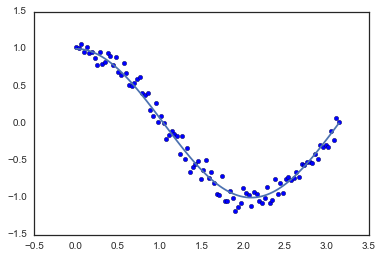

In [5]:
plt.plot(X, y_true)
plt.scatter(X, y)

<hr>

<b>Exercise</b> Estimate this model using <font face ="Courier">sklearn.neighbors.KNeighborsRegressor</font> with five neighbors. 

Use the pair <font face ="Courier">(X, y)</font> as data. 

Then print your predicted model against <font face ="Courier">y_true</font>.

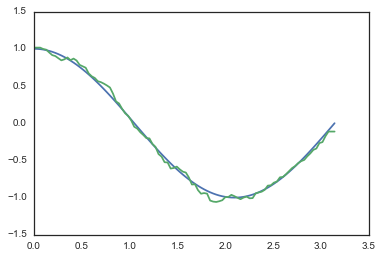

In [9]:
# Instantiate the estimator
knn = skn.KNeighborsRegressor(n_neighbors = 5)

# Fit 
knn.fit(X, y)

# Predict
yhat = knn.predict(X)

# Plots
fig, ax = plt.subplots(1)
ax.plot(X, y_true)
ax.plot(X, yhat)

<b>Discussion</b> 

+ What happens to the model as you change $K$, the number of neighbors? 

+ Specifically, what happens at the extremes $K \rightarrow 1$ and $K \rightarrow \infty$? 

+ How can we choose the optimal $K$?

<hr>

# K-Fold Cross-Validation

<font size = 1>Note: The "K" in "K-fold" has nothing to do with the "K" in "K-nearest neighbors" 

<b>Exercise</b> Check out the function <font face="Courier">sklearn.cross_validation.KFold</font>. What does each of its arguments do?

In [10]:
kf = skv.KFold(n = 8, n_folds = 4, shuffle = False)

In [11]:
for train_index, test_index in kf:
    print(train_index, test_index)

[2 3 4 5 6 7] [0 1]
[0 1 4 5 6 7] [2 3]
[0 1 2 3 6 7] [4 5]
[0 1 2 3 4 5] [6 7]


<b>Discussion</b> 

+ Why would this be useful? Compare with just holding out a test set as we did last time.

+ Specifically, if we were to divide the data we just created, should we set <font face="Courier">shuffle</font> to  <font face="Courier">True</font> or <font face="Courier">False</font>?

<b>Exercise (1) </b> Use <font face="Courier">KFold</font> to divide your data into 3 folds. 

Train using <font face="Courier">sklearn.linear_model.KNeighborRegressor</font> on each training set. 

Each time you train the model, <font face="Courier">sklearn.metrics.mean_squared_error</font> to compute and print the $MSE$ on train and test sets.


<b>Exercise (2) </b> Redo the exercise, but now increase the number of folds. What happens to the $R^2$?

In [13]:
n_obs = 1000

X, y_true, y = generate_data(n_obs, a = 1, sigma = .1)

kf = skv.KFold(n = n_obs, n_folds = 3, shuffle = True)

knn = skn.KNeighborsRegressor(n_neighbors = 100)

for train_index, test_index in kf:
    
    X_train, y_train = X[train_index, :], y[train_index,:]
    X_test, y_test = X[test_index, :], y[test_index,:]
    knn.fit(X_train, y_train)
    yhat_test = knn.predict(X_test)
    yhat_train = knn.predict(X_train)
    
    mse_test = skm.mean_squared_error(y_true = y_test, y_pred = yhat_test)
    mse_train = skm.mean_squared_error(y_true = y_train, y_pred = yhat_train)
    
    print("Train MSE", mse_train, "; Test MSE", mse_test)

Train MSE 0.0108463787877 ; Test MSE 0.0105791458112
Train MSE 0.0105253921867 ; Test MSE 0.011803183135
Train MSE 0.0109746551159 ; Test MSE 0.0106533457389


<b>Discussion</b> Many statisticians and machine learning practitioners advocate for a number of folds of the order of $K = 5$ or $K = 10$. However, the standard in econometrics is *leave-one-out* practice of $K = n$. Name some arguments for and against either of these.

# Validation Curves

Sometimes it's useful to plot the influence of a single tuning parameter on the training score and the validation score to find out whether the estimator is overfitting or underfitting.

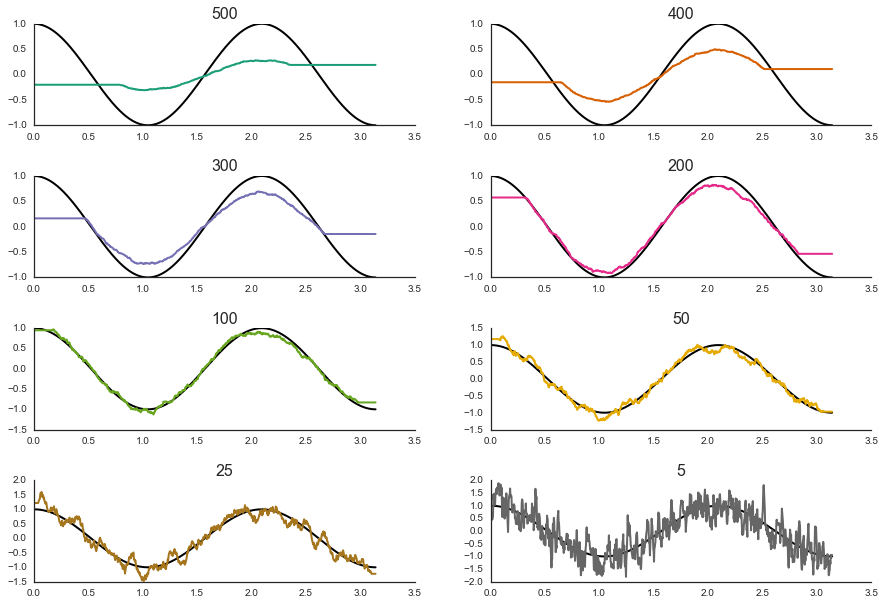

In [14]:
X, y_true, y = generate_data(1000, a = 3, sigma = 1)
n_neighbors_list = [500, 400, 300, 200, 100, 50, 25, 5]


fig, ax = plt.subplots(4, 2, figsize = (15,10))
fig.subplots_adjust(hspace = .5)

colors = plt.cm.Dark2(np.linspace(0,1, len(n_neighbors_list)))

for k, n_neighbors in enumerate(n_neighbors_list):
    
    knn = skn.KNeighborsRegressor(n_neighbors = n_neighbors)
    knn.fit(X, y)
    yhat = knn.predict(X)
    
    i,j = np.unravel_index(k, ax.shape)
    ax[i,j].plot(X, y_true, linewidth = 2, color = "black")
    ax[i,j].plot(X, yhat, linewidth = 2, color = colors[k])
    ax[i,j].set_title(label = str(n_neighbors), fontsize = 16)
    sns.despine()

<b>Discussion</b> 

+ For which values is this <i>under</i>fitting? How about <i>over</i>fitting? 

+ What is your guess for the optimal value of neighbors?

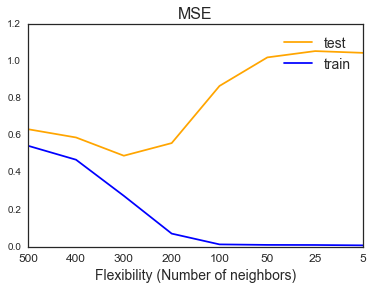

In [15]:
X, y_true, y = generate_data(1000, a = 3, sigma = .1)

n_neighbors_list = [500, 400, 300, 200, 100, 50, 25, 5]

# Scikit-learn has built-in validation curve
train_scores, test_scores = skc.validation_curve(estimator = skn.KNeighborsRegressor(),
                                                 X = X, y = y,
                                                 param_name = "n_neighbors", 
                                                 param_range = n_neighbors_list,
                                                 scoring = "mean_squared_error", 
                                                 cv = 3)

# Note the totally counter-intuitive sign flipping here!
mse_train = -train_scores
mse_test = -test_scores

fig, ax = plt.subplots(1)

# Plotting the mean of the CV-estimated MSE on test and training set
p = ax.plot(mse_test.mean(axis = 1), color = "orange", label = "test")
p = ax.plot(mse_train.mean(axis = 1), color = "blue", label = "train")


p = ax.set_xticklabels(n_neighbors_list,  size='large')
p = ax.set_xlabel("Flexibility (Number of neighbors)", fontsize = 14)
p = ax.set_title("MSE", fontsize = 16)
p = ax.legend(fontsize = 14)

<b>Discussion</b> 

+ What is contributing for the increasing in test error as the model becomes more flexible?

+ What happens if we increase the number of observations?

+ What happens if we change $a$ in <font face="Courier">generate_data</font>?